# Benchmarking models of glycolysis

In this notebook, we construct models of glycolysis using a stoichiometric network as a scaffold. Separate rate laws are then used to model the individual reactions, and the simulation results are compared with each other to explore how well simple rate laws approximate complex rate laws.

In [1]:
import numpy as np
import BondGraphTools as bgt
import matplotlib as mpl
from matplotlib import pyplot as plt
import glycolysis_models
from glycolysis_models import (GlycolysisGK, GlycolysisMM, GlycolysisMA,
    GlycolysisGK_Static, GlycolysisMM_Static, GlycolysisMA_Static)
from bgt_juliasim import simulate

import sys
import bgt_extensions as bgex

## Glycolysis model
We consider the model of glycolysis in the figure below, adapted from Mason and Covert (doi: 10.1016/j.jtbi.2018.10.041).

<img src="glycolysis.svg" style="width: 700px;"/>

As shown in the figure above, we benchmark three rate laws for this model: the generalised kinetics rate law (used in Mason and Covert), Michaelis-Menten and mass action.

### Generalised kinetics model

In the code below, we construct the generalised kinetics model and run a simulation. As expected, the steady state is consistent with that used in Mason and Covert.

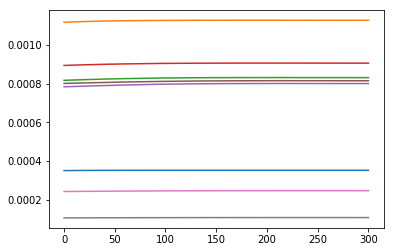

In [2]:
GK_model = GlycolysisGK()

# Define initial conditions
ic = glycolysis_models.default_initial_conditions
# Map onto state space
x0 = np.array(np.zeros(len(GK_model.state_vars)))
for i,v in enumerate(GK_model.state_vars.values()):
    species_name = v[0].name
    x0[i] = ic[species_name]
    
tspan = (0.0,300.0)
cv = bgex.gather_cv(GK_model)
sol = simulate(GK_model,tspan,x0,control_vars=cv)
plt.figure()
plt.plot(sol.t,sol.u)
plt.show()

### Michaelis-Menten model
The code below constructs the Michaelis-Menten model. Its steady state agrees with the generalised kinetics model.

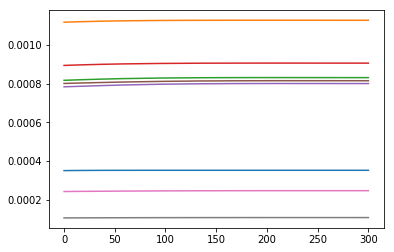

In [3]:
MM_model = GlycolysisMM()
cv = bgex.gather_cv(MM_model)
tspan = (0.0,300.0)
sol = simulate(MM_model,tspan,x0,control_vars=cv)
plt.figure()
plt.plot(sol.t,sol.u)
plt.show()

### Mass action model
The code below constructs the Michaelis-Menten model. Its steady state agrees with the other two models.

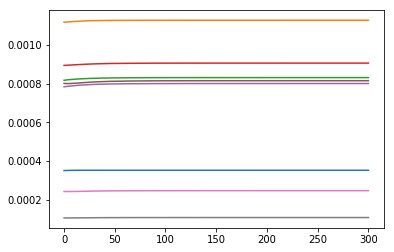

In [4]:
MA_model = GlycolysisMA()
cv = bgex.gather_cv(MA_model)
tspan = (0.0,300.0)
sol = simulate(MA_model,tspan,x0,control_vars=cv)
plt.figure()
plt.plot(sol.t,sol.u)
plt.show()

## Perturbation simulations
### Instantaneous perturbations
In the code below, we benchmark the separate rate laws against each other. This is done by performing instantaneous perturbations of the internal species and comparing the results. Specifically, the concentration of each internal species is increased/decreased by 30%. For each perturbation, we record the relaxation time defined as the final point in time where the model is over 5% of the maximum deviation.

The code below defines the models and sets plotting options.

In [5]:
from glycolysis_models import internal_perturbation, plot_internal_perturbation
GK_model = GlycolysisGK_Static()
MM_model = GlycolysisMM_Static()
MA_model = GlycolysisMA_Static()
GK_model.update_constitutive_relations()
MM_model.update_constitutive_relations()
MA_model.update_constitutive_relations()

from plot_options import set_color_palette
set_color_palette()
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'sans-serif' : ['Helvetica','Arial','DevaVu Sans'],
        'size': 13
        }
mpl.rc('font', **font)
mpl.rc('xtick', direction='in')
mpl.rc('ytick', direction='in')
mpl.rc('legend', frameon=False)

As seen in the plots below, the generalised kinetics and Michaelis-Menten rate laws behave similarly. However, the mass action rate law has a shorter response time and also tends to cause perturbations of greater magnitudes. This pattern is common across all perturbations, and occurs whether the species are increased or reduced in concentration.

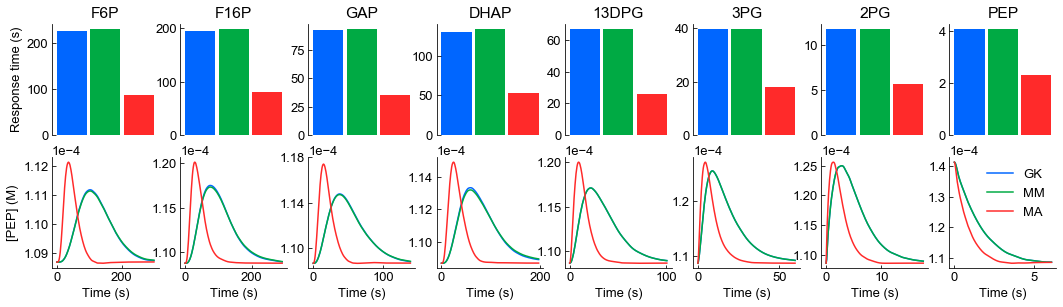

In [6]:
perturbation = 0.3
sim_results,relax_times = internal_perturbation(GK_model,MM_model,MA_model,perturbation)
fig_in_up,ax_in_up = plot_internal_perturbation(sim_results,relax_times)
ax_in_up[1,2].set_yticks(np.arange(1.1,1.21,0.04)*1e-4)
plt.show()

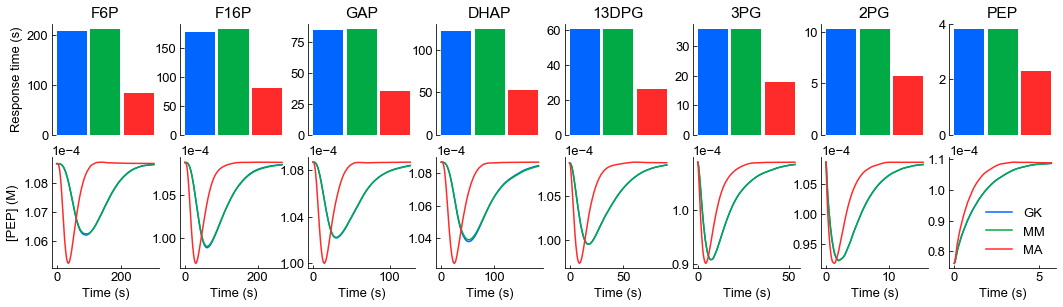

In [7]:
perturbation = -0.3
sim_results,relax_times = internal_perturbation(GK_model,MM_model,MA_model,perturbation)
fig_in_down,ax_in_down = plot_internal_perturbation(sim_results,relax_times)
ax_in_down[1,2].set_yticks(np.arange(1.0,1.1,0.04)*1e-4)
plt.show()

## Prolonged perturbation

In the code below, we compare the models under prolonged perturbations. To model this, we change the concentrations of the external species held at constant concentrations. This causes the model to relax to a different steady state. As with the internal perturbations, we record the response time and the steady state deviation.

In contrast to internal perturbations, the generalised kinetics rate law and Michaelis-Menten rate laws behave quite differently. Nonetheless, they seem to exhibit similar qualitative behaviour, whereas the mass action model is qualitatively different for several species.

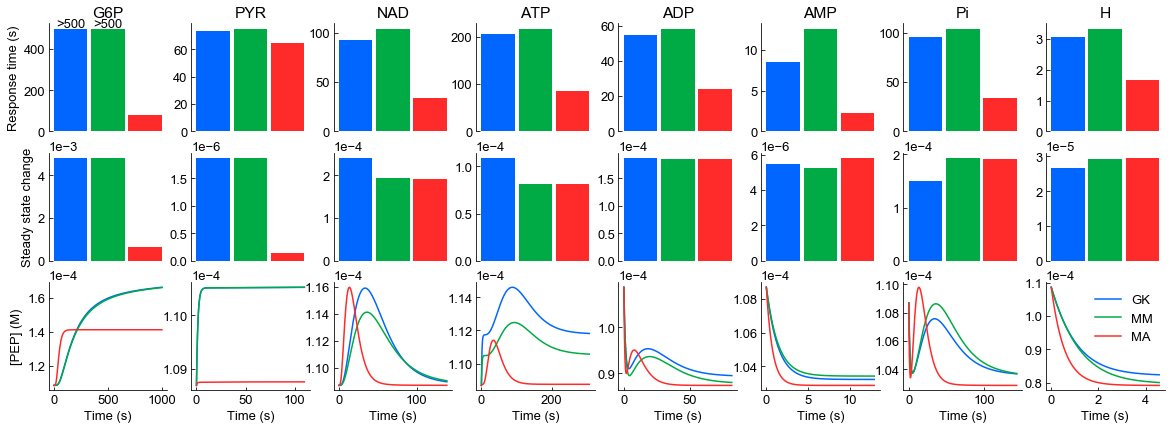

In [10]:
from glycolysis_models import external_perturbations, plot_external_perturbation
perturbation = 0.3
sim_results,relax_times,ss_dev = external_perturbations(GK_model,MM_model,MA_model,perturbation)
fig_ex_up,ax_ex_up = plot_external_perturbation(sim_results,relax_times,ss_dev)
ax_ex_up[2,2].set_yticks(np.arange(1.1,1.17,0.02)*1e-4)
plt.show()

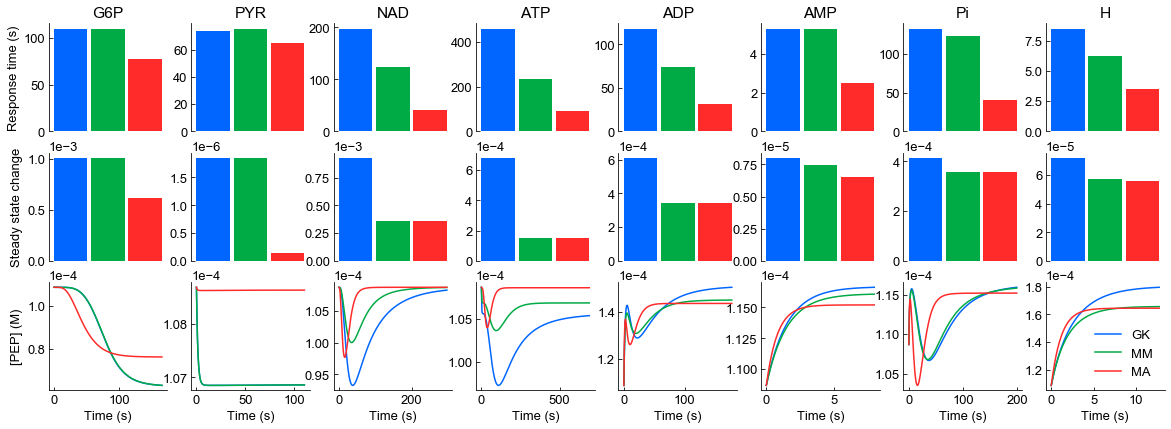

In [11]:
perturbation = -0.3
sim_results,relax_times,ss_dev = external_perturbations(GK_model,MM_model,MA_model,perturbation)
fig_ex_down,ax_ex_down = plot_external_perturbation(sim_results,relax_times,ss_dev)

In [12]:
from general import save_figure
save_figure(fig_in_up,"output/gly_internal_up")
save_figure(fig_in_down,"output/gly_internal_down")
save_figure(fig_ex_up,"output/gly_external_up")
save_figure(fig_ex_down,"output/gly_external_down")

## Energetic analysis

An benefit of bond graph modelling is that one can analyse the energetics of the glycolysis pathway. In the code below, we run such an analysis, isolating the glycolysis pathway by switching off the fbp and pps enzymes.

In [13]:
GK_model = GlycolysisGK()
GK_model.enzyme_concentrations["fbp"] = 0
GK_model.enzyme_concentrations["pps"] = 0
#GK_model.update_constitutive_relations
x0 = glycolysis_models.x_ss

tspan = (0.0,1000.0)
cv = bgex.gather_cv(GK_model)
sol = simulate(GK_model,tspan,x0,control_vars=cv)
x_ss = sol.u[-1]
V_ss = {r:glycolysis_models.compute_flux(GK_model,r,x_ss) for r,_,_ in GK_model.reactions}
V_ss

{'pgi': 7.063372560267981e-05,
 'pfk': 7.06337255989574e-05,
 'fbp': 0.0,
 'fba': 7.063372590252885e-05,
 'tpi': 7.063372632673794e-05,
 'gap': 0.0001412674527507606,
 'pgk': 0.0001412674534556219,
 'gpm': 0.00014126745400218672,
 'eno': 0.0001412674541415893,
 'pyk': 0.00014126745424592922,
 'pps': -0.0}

In the code below, we calculate the affinity of the glycolysis pathway, by calculating the free energy of the reaction

$$
\mathrm{G6P + 3ADP + 2NAD + 2Pi \rightleftharpoons 2PYR + 3ATP + H + 2NADH + 2H2O}
$$

In [15]:
from copy import deepcopy
R = glycolysis_models.R

def reaction_affinity(model,reaction,x):
    T = 310
    exp_Af,exp_Ar = glycolysis_models.split_ma_terms(model,reaction,x)
    Af = R*T*np.log(exp_Af)
    Ar = R*T*np.log(exp_Ar)
    return Af-Ar

def gather_params(model,potentials):
    params = deepcopy(model.chemostat_parameters)
    for k,v in potentials.items():
        params[k] = v
    return params

def glycolysis_affinity(model,potentials={},RT=R*310):
    params = gather_params(model,potentials)
    Af = params["G6P"] + 3*params["ADP"] + 2*params["NAD"] + 2*params["Pi"]
    Ar = 2*params["PYR"] + 3*params["ATP"] + params["H"] + 2*params["NADH"] + 2*params["H2O"]
    return RT*(Af-Ar)

glycolysis_affinity(GK_model)

449362.96429251693

This pathway affinity can be broken up into contributions from individual reactions, since the pathway consists of
$$
\mathrm{pgi + pfk + fba + tpi + 2gap + 2pgk + 2gpm + 2eno + 2pyk}
$$

Thus, the contribution of each reaction to overall affinity can be calculated as shown below. As expected, these sum to the affinity of the glycolysis pathway.

In [16]:
d_pathway = {
    "pgi": 1,
    "pfk": 1,
    "fbp": 0,
    "fba": 1,
    "tpi": 1,
    "gap": 2,
    "pgk": 2,
    "gpm": 2,
    "eno": 2,
    "pyk": 2,
    "pps": 0,
}

total_A = 0
for r,_,_ in GK_model.reactions:
    A = reaction_affinity(GK_model,r,x_ss)
    print(f"{r}: {A}")
    A_scaled = d_pathway[r]*A
    total_A += A_scaled
    
print(f"Total affinity: {total_A}")

pgi: 43360.43320699195
pfk: 80999.15620072084
fbp: 40796.32067399659
fba: 14647.589424216389
tpi: 8404.01214834867
gap: 51459.25393910731
pgk: 23941.608286999282
gpm: 13499.379404040827
eno: 45080.76730484272
pyk: 16994.877721129393
pps: -20068.999749335766
Total affinity: 449362.9642925169
